In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import export_text, DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("stress_detection.csv", index_col=0)
df

,day,PSS_score,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,sleep_time,wake_time,sleep_duration,PSQI_score,call_duration,num_calls,num_sms,screen_on_time,skin_conductance,accelerometer,mobility_radius,mobility_distance
participant_id,,,,,,,,,,,,,,,,,,,
1,1,34,2.322732,4.332193,1.185878,1.570213,3.782094,7.726792,5.190660,6.572069,1,3.924527,12,32,10.703714,3.115730,0.161717,1.145179,2.196851
1,2,37,1.761436,3.254120,3.907281,4.072512,1.997145,7.312674,6.170717,8.030168,4,58.318004,3,41,11.012939,0.959144,0.985587,1.021133,0.737825
1,3,30,3.025887,1.855002,2.045900,2.317493,3.619225,6.992060,5.318825,7.102420,1,4.941043,4,48,4.877372,3.311629,1.877445,0.478179,0.911673
1,4,16,1.948370,4.966676,3.345225,1.607756,3.583524,8.886914,8.061075,8.123294,3,0.295373,11,38,3.462956,0.625721,0.494921,0.630549,3.911418
1,5,32,3.343484,2.065936,3.137843,2.118061,2.567347,7.811705,7.312145,7.785143,3,22.300571,17,17,4.861046,0.622609,1.342600,0.254090,1.605132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,26,30,2.529821,2.339608,1.321208,4.204331,4.890738,8.823033,8.703758,8.661936,2,59.106125,0,1,11.339248,4.045863,1.694037,0.859401,4.123621
100,27,33,1.319100,4.500507,4.816983,2.416180,4.195933,5.260243,5.890244,6.456058,4,56.137068,12,17,10.694380,2.169768,1.657737,0.108480,2.242326
100,28,30,1.899102,3.930147,4.047799,3.163160,2.559401,6.425568,7.978066,7.188921,3,58.102473,13,21,8.646478,4.995654,1.046666,0.508623,2.088313


In [3]:
## Actual cross validation that we plan to use ###

# Get unique participant IDs
unique_ids = df.index.unique()

# Shuffle the IDs
np.random.seed(0) # Not truly random!
shuffled_ids = np.random.permutation(unique_ids)

# Split the IDs
n_train = int(len(shuffled_ids) * 0.8)
n_val = int(len(shuffled_ids) * 0.1)
n_test = len(shuffled_ids) - n_train - n_val

train_ids = shuffled_ids[:n_train]
val_ids = shuffled_ids[n_train:n_train + n_val]
test_ids = shuffled_ids[n_train + n_val:]

# Filter rows by IDs
train_data = df[df.index.isin(train_ids)]
val_data = df[df.index.isin(val_ids)]
test_data = df[df.index.isin(test_ids)]

# Print sizes
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 2400
Validation size: 300
Test size: 300


In [4]:
X_train, y_train = train_data.drop(columns="PSS_score"), train_data.PSS_score
X_val, y_val = val_data.drop(columns='PSS_score'), val_data.PSS_score
X_test, y_test = test_data.drop(columns='PSS_score'), test_data.PSS_score

In [5]:
best_score = float('inf')
best_params = None
results = []

max_depth_range = range(1, 21)  # Example: 1 to 20
min_impurity_decrease_range = np.arange(0.0, 0.5, 0.05)

# Loop through each of our parameters to do grid search by hand
for max_depth in max_depth_range:
    for min_impurity_decrease in min_impurity_decrease_range:
        # Create model
        model = DecisionTreeRegressor(
            criterion='squared_error',
            max_depth=max_depth,
            min_impurity_decrease=min_impurity_decrease
        )
        model.fit(X_train, y_train)
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        
        # Update results
        results.append({
            'max_depth': max_depth,
            'min_impurity_decrease': min_impurity_decrease,
            'val_mse': val_mse
        })
        if val_mse < best_score:
            best_score = val_mse
            best_params = {'max_depth': max_depth, 'min_impurity_decrease': min_impurity_decrease}

results_df = pd.DataFrame(results)
print(f"Best parameters: {best_params}")
print(f"Best validation MSE: {best_score}")


Best parameters: {'max_depth': 1, 'min_impurity_decrease': 0.45}
Best validation MSE: 74.31869600694445


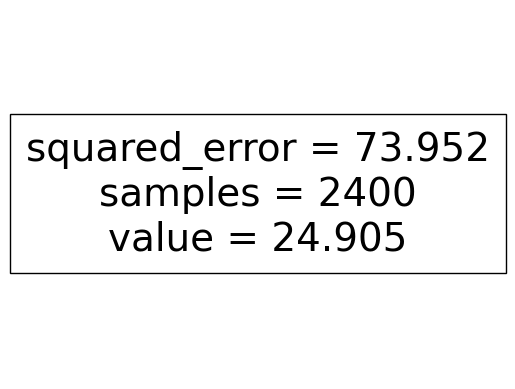

In [6]:
model = DecisionTreeRegressor(criterion='squared_error', max_depth=1, min_impurity_decrease=0.45)
# model = DecisionTreeRegressor(criterion='squared_error', max_depth=2)
model.fit(X_train, y_train)
fig = plt.figure()
_ = tree.plot_tree(model,feature_names=X_train.columns)
# print(export_text(model, feature_names=X.columns))

# Notes from prof:
# Check MSE train and MSE test against each other
# try min_impurity_decrease in regressor
# only show first 3 layers on slides and interpret them, bigger font (make readable)
# maybe decrease max_depth as last step

In [7]:
### MSE of our model on test data ###
y_val_hat = model.predict(X_test)
mean_squared_error(y_val, y_val_hat)

74.31869600694445

In [8]:
### Creating a tree with max_depth=4 performs worse than a model that guesses the mean ###
model = DecisionTreeRegressor(criterion='squared_error', max_depth=4)
model.fit(X_train, y_train)

y_model_val_hat = model.predict(X_val)
mean_squared_error(y_true=y_val, y_pred=y_model_val_hat)

76.09797909791067

In [9]:
### A linear model still does worse than guessing the mean each time ###
from sklearn.linear_model import LinearRegression
used_variables = ["Openness", "Neuroticism", "mobility_distance"]
X_train2 = X_train[used_variables]
X_val2 = X_val[used_variables]
linear_model = LinearRegression()
linear_model.fit(X_train2, y_train)
y_hat2_linear = linear_model.predict(X_val2)
mean_squared_error(y_true=y_val, y_pred=y_hat2_linear)

75.31241637627242